# Effects of taVNS on physiological features
## Discription of dataset
2 groups (true label temporally unknown, each patient received VNS for several days during which there were 2 sessions of stimulation). Subject ID from 2020004 to 2020015.

**Warning**: Both the number of days and the number of sessions depend on the subject.
## Objective
- label the features according to the stimulation onsets/offsets
- perform statistical analyse

## Input
- nn_interval or other physiological features file (.pickle) for each subject
- stimulation onset information (stim_time_sum.txt) indicating when the stimulation begins 

## Output
- labeled features for example pre/during/post
- statistical analyses results

## detailed target
### Heart Rate Variability
- 20 minutes before, during, and after compared between two groups: stimulation and sham
    - Further broken down by time epochs (for example, first 3 days of monitoring vs last 3 days of monitoring)
- Change over time: HRV of 1 hour (for example, taken from 0200-0300) daily over recording period to see how resting HRV may change over the course of monitoring
    - Compare between treatments groups: stimulation and sham
- QRS length
a.	20 minutes before, during, and after compared between two groups: stimulation and sham
i.	Further broken down by time epochs (for example, first 3 days of monitoring vs last 3 days of monitoring)
b.	Change over time
i.	1 hour average (for example, taken from 0200-0300) daily over recording period to see how resting HRV may change over the course of monitoring
1.	Compare between treatments groups: stimulation and sham

- Heart Rate
i.	Averaged over the 2 hours before a treatment session
ii.	Averaged over the 2 hours after a treatment session
iii.	Averaged over the 2-4 hour time points after a treatment session
iv.	Averaged over the 4-6 hour time points after a treatment session
- Blood pressure (MAP, mean arterial pressure and non invasive blood pressure, NIBP)
    - i.	Averaged over the 2 hours before a treatment session
    - ii.	Averaged over the 2 hours after a treatment session
    - iii.	Averaged over the 2-4 hour time points after a treatment session
    - iv.	Averaged over the 4-6 hour time points after a treatment session

- ICP (intracranial pressure), collected only in patients with an invasive monitor placed
    - i. Averaged over the 2 hours before a treatment session
    - ii.	Averaged over the 2 hours after a treatment session
    - iii.	Averaged over the 2-4 hour time points after a treatment session
    - iv.	Averaged over the 4-6 hour time points after a treatment session


## Workflow
### 1. label NN intervals and QRS length with date and group (pre/during/after)
### 2. exctract 1 hour average

## Notes:
The unit of time in the feature csv is second.

In [314]:
# import and settings
import os
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from hrvanalysis import get_time_domain_features
# from hrvanalysis import get_geometrical_features
from hrvanalysis import get_frequency_domain_features
import pingouin as pg
import seaborn as sns

def datetime2time_s(datetime_object):
    '''
    if datetime is a series, no vectorized operation is possible
    '''
    if isinstance(datetime_object, (list, np.ndarray)):
        time_s = []
        for i in datetime_object:
            hours = i.hour
            minutes = i.minute
            seconds = i.second
            time_s.append(datetime.timedelta(hours=hours, minutes=minutes, 
                                seconds=seconds).total_seconds())
    else:  # scalar
        hours = datetime_object.hour
        minutes = datetime_object.minute
        seconds = datetime_object.second
        time_s=datetime.timedelta(hours=hours, minutes=minutes, 
                                seconds=seconds).total_seconds()
    return time_s

def save_eps(fig, fName):
    fig.savefig(fName + '.eps', format='eps')
    return True

data_dir = os.path.expanduser("~/Desktop/GT/ECG_VNS/data")
stim_time_sum_fName = os.path.join('/Users/ganshengt/Box/taVNS_clinical/stim_time', 'stim_time_sum.txt')
df_stim_time_sum = pd.read_csv(stim_time_sum_fName, encoding='utf-16', sep="\t", usecols=np.arange(4))
df_assignment = pd.read_excel(os.path.join(data_dir, 'Treatment Group Assigner.xlsx'))
df_assignment = df_assignment.dropna()
df_assignment['Parent Study ID Number'] = df_assignment['Parent Study ID Number'].astype(int)
features_nn_1hour_fName = os.path.join('/Users/ganshengt/Box/taVNS_clinical/features', 'features_nn_1hour.csv')
array_subjs = df_stim_time_sum['subject'].unique()

## Extract features for 1 hour interval (0200-0300)
The output format is:

| subj  | date |   time    |    group      |  features  |
| ----- | ---- | --------- | ------------- | ---------- |
|2020014| 2/23 | in second |  stim/sham    |    value   |

In [92]:
# from 0200 to 0300
hours2extract = [2]  # can be used to extract minutes or seconds 
# define output df structure
features_2df = {'subject' : [],
                'date':[],
                'time': [],
                'group': [],
                'nn_interval': []}

# array_subjs = [2020012]  # 4 tests

for subj in array_subjs:
    feature_filename = os.path.join(data_dir, str(subj) + '.pickle')
    df_feature = pd.read_pickle(feature_filename)
    # iterate each row for generic purpose (hours2extract is a list)
    for index, row in df_feature.iterrows():
        if row['timestamp'].hour in hours2extract:
            features_2df['subject'].append(subj)
            features_2df['date'].append(row['timestamp'].strftime('%-m/%d/%y'))
            features_2df['time'].append(datetime2time_s(row['timestamp']))
            group_num = df_assignment[df_assignment['Parent Study ID Number'] == subj]['Treatment Assignment (0= Sham, 1= Stim)'].values[0]
            if group_num == 0:
                features_2df['group'].append('Sham')
            elif group_num == 1:
                features_2df['group'].append('Stim')
            features_2df['nn_interval'].append(row['nn_interval'])
            
df_features = pd.DataFrame(features_2df)
df_features.to_csv(features_nn_1hour_fName)

## Extract features (nn_interval) and label them as pre/during/post stim
The out put format is:

| subj  | date |   time    |     group     |      session     |  features  |
| ----- | ---- | --------- | ------------- | ---------------- | ---------- |
|2020014| 2/23 | in second |  stim/sham    |  pre/during/post |    value   |

time is kept to second, we can easily identify them as am/pm afterwards

In [163]:
# define output df structure
def identify_session(timestamp_in_second, stim_onset, stim_offset, session_length):
    '''
    inputs
    ------
    timestamp_in_second: float
        timestamp of the measure
    stim_onset: array
    stim_offset: array
        should have the same shape as stim_offset
    session_length: float
        in seconds
    outputs
    -------
    session: str
        'pre', 'during', or 'post'
    '''
    for i in range(len(stim_onset)):
        if stim_onset[i] - session_length < time_s < stim_onset[i]:
            return "pre"
        elif stim_onset[i] < time_s < stim_offset[i]:
            return "during"
        elif stim_offset[i] < time_s < stim_offset[i] + session_length:
            return "post"
    return False
        
def extract_date(datetime):
    return datetime.date()
#     return datetime.strftime('%-m/%d/%y')

def int_2_datetime_date(input_int):
    '''
    function valid in 21 centruy
    '''
    input_str = str(input_int)
    date = datetime.date(year=int('20' + input_str[0:2]), month=int(input_str[2:4]), day=int(input_str[4:6]))
    return date
    
features_2df = {'subject' : [],
                'date':[],
                'time': [],
                'group': [],
                'session': [],
                'nn_interval': []}

# array_subjs = [2020012]  # 4 tests

# definition
session_length = 20 * 60
features_nn_preDuringPost_fName = os.path.join('/Users/ganshengt/Box/taVNS_clinical/features', 'features_nn_preDuringPost.csv')

for subj in array_subjs:
    feature_filename = os.path.join(data_dir, str(subj) + '.pickle')
    df_feature = pd.read_pickle(feature_filename)
    df_info_per_subj = df_stim_time_sum[df_stim_time_sum['subject'] == subj]
    dates = pd.unique(df_info_per_subj['date'])
    dates_datetime = []
    for date in dates:
        dates_datetime.append(int_2_datetime_date(date))
    dates_datetime = np.array(dates_datetime)
    
#     dates_datetime = dates_datetime[0:2] # 4test
    
    date_col = df_feature['timestamp'].apply(extract_date)
    df_feature['date'] = date_col
    for date in dates_datetime:
        df_feature_filtered_by_date = df_feature[df_feature['date']==date]
        onsets_per_subj_day = df_info_per_subj[(df_info_per_subj['date'] == int(date.strftime('%y%m%d'))) & (df_info_per_subj['event'] == 'stim_onset')]['time'].values
        offsets_per_subj_day = df_info_per_subj[(df_info_per_subj['date'] == int(date.strftime('%y%m%d'))) & (df_info_per_subj['event'] == 'stim_offset')]['time'].values
        for index, row in df_feature_filtered_by_date.iterrows():
            time_s = datetime.timedelta(hours=row['timestamp'].hour, minutes=row['timestamp'].minute, 
                            seconds = row['timestamp'].second).total_seconds()
            session = identify_session(time_s, onsets_per_subj_day, offsets_per_subj_day, session_length)
            if session:
                features_2df['subject'].append(subj)
                features_2df['date'].append(date)
                features_2df['time'].append(time_s)
                group_num = df_assignment[df_assignment['Parent Study ID Number'] == subj]['Treatment Assignment (0= Sham, 1= Stim)'].values[0]
                if group_num == 0:
                    features_2df['group'].append('Sham')
                elif group_num == 1:
                    features_2df['group'].append('Stim')
                features_2df['session'].append(session)
                features_2df['nn_interval'].append(row['nn_interval'])
            else:
                continue
#         for stim_id in range(len(onsets_per_subj_day):
            
#     for index, row in df_feature.iterrows():
#         # date conversion
#         date = row['timestamp'].strftime('%-m/%d/%y')
#         time_s = datetime.timedelta(hours=row['timestamp'].hour, minutes=row['timestamp'].minute, 
#                             seconds = row['timestamp'].second).total_seconds()
        
#         df_info_per_subj_day = df_info_per_subj[df_info_per_subj['date'] == date]
#         onset_pre_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '1'].reset_index()['time_s'].astype(float)\
#         - VNS_duration
#         offset_pre_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '1'].reset_index()['time_s'].astype(float)

#         onset_post_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '0'].reset_index()['time_s'].astype(float)
#         offset_post_VNS = df_info_per_subj_day[df_info_per_subj_day['switch'] == '0'].reset_index()['time_s'].astype(float)\
#         + VNS_duration
#         time = am_or_pm(time_s)
df_features = pd.DataFrame(features_2df)
df_features.to_csv(features_nn_preDuringPost_fName)

## HRV extraction and Statistical analysis
HRV is defined as the variation of the NN (RMSSD for example)

the calculation takes 4 minutes

change 3 to three for the beauty

In [301]:
df_features = pd.read_csv(features_nn_preDuringPost_fName, index_col=0)  # read csv
df_features = df_features.dropna()
noon = 12 * 60 * 60
am_pm = ['am' if time < noon else 'pm' for time in df_features['time']]
df_features['am_pm'] = am_pm
data2df_hrv = []
less_than_four_days=False
for subj in pd.unique(df_features['subject']):
    df_temp = df_features[df_features['subject']==subj]  # temporary df to retrieve stim dates for a subject  
    if pd.unique(df_temp['date']).shape[0] < 4:
        less_than_four_days = True
    else:
        first_three_days = pd.unique(df_temp['date'])[:3]
        last_three_days = pd.unique(df_temp['date'])[-3:]
    for date in pd.unique(df_temp['date']):
        if less_than_four_days:
            pass
        elif date in first_three_days:
            three_days_timeepochs = 'first_three_days'
        elif date in last_three_days:
            three_days_timeepochs = 'last_three_days'
        else:
            three_days_timeepochs = 'noLabel'
        df_temp = df_features[(df_features['subject']==subj) & (df_features['date']==date)]        
        for am_pm in pd.unique(df_temp['am_pm']):
            df_temp = df_features[(df_features['subject']==subj) & (df_features['date']==date) &\
            (df_features['am_pm']==am_pm)]
            for session in pd.unique(df_temp['session']):
                data2calculate_hrv = df_features[(df_features['subject']==subj) & (df_features['date']==date) &\
                                                 (df_features['am_pm']==am_pm) & (df_features['session']==session)]
                time_domain_features = get_time_domain_features(data2calculate_hrv['nn_interval'].astype(float))
                frequency_domain_features = get_frequency_domain_features(data2calculate_hrv['nn_interval'].astype(float))
                data2df_hrv.append([subj, date, am_pm, session, data2calculate_hrv['group'].values[0], str(subj) + str(date) + str(am_pm), three_days_timeepochs] +
                                   list(time_domain_features.values()) +\
                                   list(frequency_domain_features.values()))

df_hrv = pd.DataFrame(data2df_hrv, columns=['subject', 'date', 'am_pm', 'session', 'group', 'subj_date_time', 'three_days_timeepochs'] + list(time_domain_features.keys()) +
                      list(frequency_domain_features.keys()))
features_hrv_fName = os.path.join('/Users/ganshengt/Box/taVNS_clinical/features', 'features_hrv.csv')
df_hrv.to_csv(features_hrv_fName)

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 13, using nperseg = 13
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 25, using nperseg = 25
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 26, using nperseg = 26
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 256 is greater than input length  = 131, using nperseg = 131
  warnings.warn('nperseg = {0:d} is greater than input length '


## mixed ANOVA analysis

In [303]:
for hrv_metric in df_hrv.columns[7:]:
    aov = pg.mixed_anova(data=df_hrv, dv=hrv_metric, within='session', subject='subject', between='group')
    print(hrv_metric)
    pg.print_table(aov)

mean_nni

ANOVA SUMMARY

Source               SS    DF1    DF2          MS      F    p-unc    np2      eps
-----------  ----------  -----  -----  ----------  -----  -------  -----  -------
group        200003.398      1      9  200003.398  4.520    0.062  0.334  nan
session         118.188      2     18      59.094  0.355    0.706  0.038    0.700
Interaction     579.130      2     18     289.565  1.741    0.204  0.162  nan

sdnn

ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
group        12325.358      1      9  12325.358  1.718    0.222  0.160  nan
session        342.071      2     18    171.036  3.232    0.063  0.264    0.828
Interaction    132.045      2     18     66.022  1.248    0.311  0.122  nan

sdsd

ANOVA SUMMARY

Source             SS    DF1    DF2        MS      F    p-unc    np2      eps
-----------  --------  -----  -----  --------  -----  -----

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


max_hr

ANOVA SUMMARY

Source             SS    DF1    DF2        MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  --------  -----  -----  --------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
group        1590.810      1      9  1590.810  0.837    0.384      nan      0.085  nan           nan        nan        nan
session        52.729      2     18    26.365  0.747    0.488        0.486  0.077    0.640         0.000      0.437      0.024
Interaction   222.171      2     18   111.085  3.149    0.067      nan      0.259  nan           nan        nan        nan

min_hr

ANOVA SUMMARY

Source            SS    DF1    DF2       MS      F    p-unc    np2      eps
-----------  -------  -----  -----  -------  -----  -------  -----  -------
group        802.707      1      9  802.707  3.896    0.080  0.302  nan
session       18.348      2     18    9.174  5.012    0.019  0.358    0.989
Interaction    6.909      

## Post-hoc tests

In [310]:
pg.pairwise_ttests(dv='min_hr', within='session', subject='subject', between='group', data=df_hrv)
# pg.pairwise_ttests(dv='rmssd', within='session', subject='subject', data=df_hrv[df_hrv['group']=='Stim'])

,Contrast,session,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,session,-,during,post,True,True,2.698485,10.000000,two-sided,2.237146e-02,3.184,0.159483
1,session,-,during,pre,True,True,-0.134400,10.000000,two-sided,8.957529e-01,0.3,-0.008222
2,session,-,post,pre,True,True,-2.639532,10.000000,two-sided,2.475385e-02,2.941,-0.165821
3,group,-,Sham,Stim,False,True,-2.003634,8.957953,two-sided,7.625409e-02,1.432,-1.094438
4,session * group,during,Sham,Stim,False,True,-6.530071,181.710078,two-sided,6.379715e-10,1.391e+07,-0.911603
5,session * group,post,Sham,Stim,False,True,-4.886456,181.589951,two-sided,2.246371e-06,6707.933,-0.684552
6,session * group,pre,Sham,Stim,False,True,-4.844460,171.568398,two-sided,2.823130e-06,5427.629,-0.695588


## Box plots

<AxesSubplot:title={'center':'Sham group'}, xlabel='session', ylabel='mean_hr'>

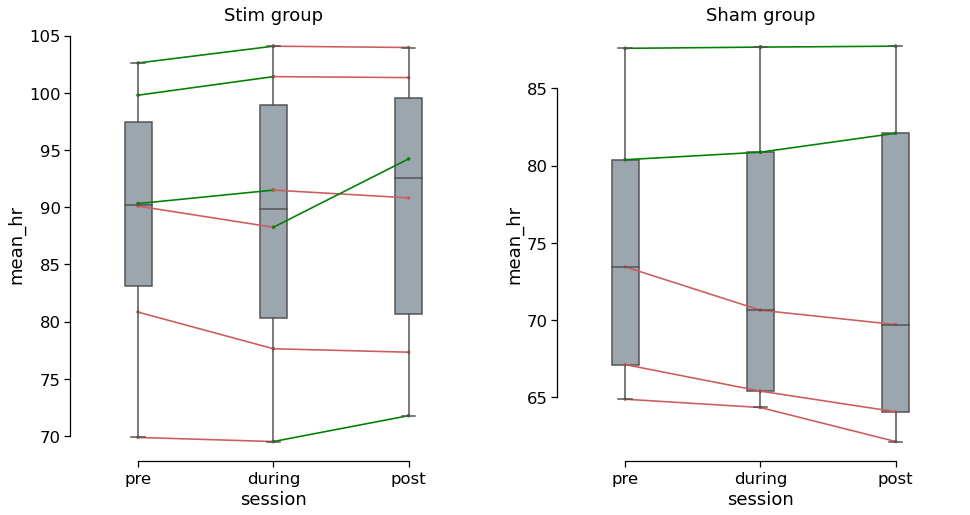

In [311]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes[0].set_title('Stim group')
axes[1].set_title('Sham group')
pg.plot_paired(data=df_hrv[df_hrv['group']=='Stim'], dv='mean_hr', within='session', subject='subject', dpi=150, ax=axes[0], order=['pre', 'during', 'post'])
pg.plot_paired(data=df_hrv[df_hrv['group']=='Sham'], dv='mean_hr', within='session', subject='subject', dpi=150, ax=axes[1], order=['pre', 'during', 'post'])

## mixed ANOVA with subj_date_time as ID

In [335]:
# check whether pre, during, post data exist for each id
df_hrv_sdtID = df_hrv.copy()
indices2drop = []
for index, row in df_hrv_sdtID.iterrows():
    sdt_id = row['subj_date_time']
    if df_hrv_sdtID[df_hrv_sdtID['subj_date_time'] == sdt_id].shape[0] < 3:
        indices2drop.append(index)
df_hrv_sdtID = df_hrv_sdtID.drop(indices2drop)

for hrv_metric in df_hrv_sdtID.columns[7:]:
    aov = pg.mixed_anova(data=df_hrv_sdtID, dv=hrv_metric, within='session', subject='subj_date_time', between='group')
    print(hrv_metric)
    pg.print_table(aov)

mean_nni

ANOVA SUMMARY

Source                SS    DF1    DF2           MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  -----------  -----  -----  -----------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
group        3144701.919      1    173  3144701.919  55.035    0.000      nan      0.241  nan           nan        nan        nan
session         2949.592      2    346     1474.796   0.847    0.429        0.421  0.005    0.886         0.000      0.871      0.000
Interaction     9308.804      2    346     4654.402   2.675    0.070      nan      0.015  nan           nan        nan        nan

sdnn

ANOVA SUMMARY

Source               SS    DF1    DF2          MS       F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
-----------  ----------  -----  -----  ----------  ------  -------  -----------  -----  -------  ------------  ---------  ---------
group        184671.200    

## Post-hoc

In [329]:
dependent_var = 'mean_hr'
pg.print_table(pg.pairwise_ttests(dv=dependent_var, within='session', subject='subject', between='group', data=df_hrv_sdtID, padjust='bonf'))
print('stim')
pg.print_table(pg.pairwise_ttests(dv=dependent_var, within='session', subject='subject', data=df_hrv_sdtID[df_hrv_sdtID['group']=='Stim'], padjust='bonf'))
print('Sham')
pg.print_table(pg.pairwise_ttests(dv=dependent_var, within='session', subject='subject', data=df_hrv_sdtID[df_hrv_sdtID['group']=='Sham'], padjust='bonf'))


POST HOC TESTS

Contrast         session    A       B     Paired    Parametric         T      dof  alternative      p-unc    p-corr  p-adjust             BF10    hedges
---------------  ---------  ------  ----  --------  ------------  ------  -------  -------------  -------  --------  ----------  -------------  --------
session          -          during  post  True      True          -0.448   10.000  two-sided        0.664     1.000  bonf                0.324    -0.014
session          -          during  pre   True      True          -1.659   10.000  two-sided        0.128     0.384  bonf                0.854    -0.062
session          -          post    pre   True      True          -0.876   10.000  two-sided        0.401     1.000  bonf                0.410    -0.046
group            -          Sham    Stim  False     True          -2.207    8.986  two-sided        0.055   nan      nan                 1.740    -1.193
session * group  during     Sham    Stim  False     True         

## Box plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


True

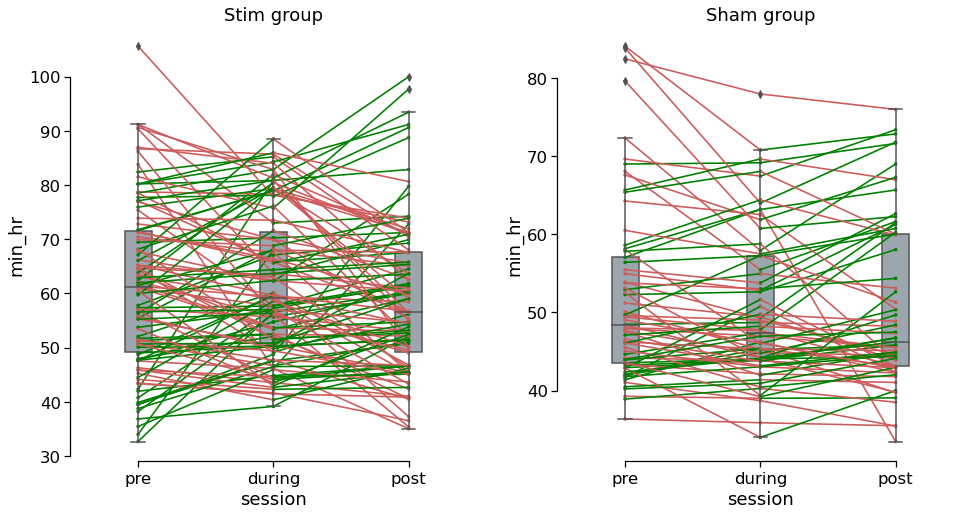

In [327]:
from matplotlib import pyplot as plt
plot_order = ['pre', 'during', 'post']
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes[0].set_title('Stim group')
axes[1].set_title('Sham group')
pg.plot_paired(data=df_hrv_sdtID[df_hrv_sdtID['group']=='Stim'], dv=dependent_var, within='session', subject='subj_date_time', dpi=150, ax=axes[0], order=plot_order)
pg.plot_paired(data=df_hrv_sdtID[df_hrv_sdtID['group']=='Sham'], dv=dependent_var, within='session', subject='subj_date_time', dpi=150, ax=axes[1], order=plot_order)
save_eps(fig, os.path.join('/Users/ganshengt/Box/taVNS_clinical/features', 'bp'))

<Figure size 720x576 with 0 Axes>

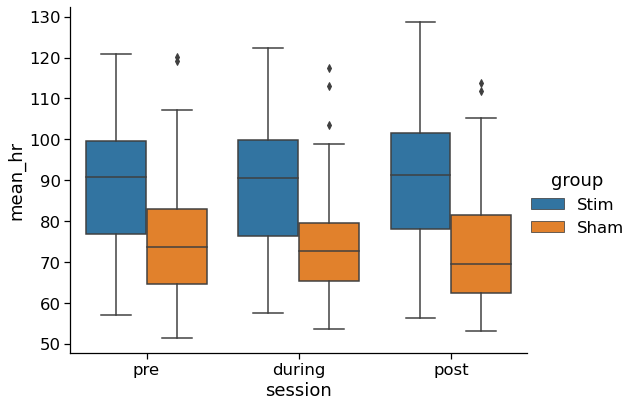

In [330]:
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(10,8))
sns.catplot(x='session', 
            y=dependent_var,
            hue="group",
            kind="box",
            data=df_hrv_sdtID, 
            height=6, 
            aspect=1.3);

## statistical analysis with three days timeepochs as within subj var, group as between suj var

In [338]:
# df_hrv_sdtID = df_hrv.copy()
# indices2drop = []
# for index, row in df_hrv_sdtID.iterrows():
#     sdt_id = row['subj_date_time']
#     if df_hrv_sdtID[df_hrv_sdtID['subj_date_time'] == sdt_id].shape[0] < 3:
#         indices2drop.append(index)
# df_hrv_sdtID = df_hrv_sdtID.drop(indices2drop)
for hrv_metric in df_hrv.columns[7:]:
    aov = pg.mixed_anova(data=df_hrv, dv=hrv_metric, within='three_days_timeepochs', subject='subject', between='group')
    print(hrv_metric)
    pg.print_table(aov)

mean_nni

ANOVA SUMMARY

Source                         SS    DF1    DF2          MS      F    p-unc    p-GG-corr    np2      eps    sphericity    W-spher    p-spher
---------------------  ----------  -----  -----  ----------  -----  -------  -----------  -----  -------  ------------  ---------  ---------
group                  184378.052      1      9  184378.052  3.883    0.080      nan      0.301  nan           nan        nan        nan
three_days_timeepochs     240.846      2     18     120.423  0.048    0.953        0.856  0.005    0.571         0.000      0.247      0.015
Interaction              2462.540      2     18    1231.270  0.495    0.618      nan      0.052  nan           nan        nan        nan

sdnn

ANOVA SUMMARY

Source                       SS    DF1    DF2        MS       F    p-unc     np2      eps
---------------------  --------  -----  -----  --------  ------  -------  ------  -------
group                  8394.350      1      9  8394.350   1.118    0.318   0

/Users/ganshengt/opt/anaconda3/envs/p38/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


cvsd

ANOVA SUMMARY

Source                    SS    DF1    DF2     MS       F    p-unc     np2      eps
---------------------  -----  -----  -----  -----  ------  -------  ------  -------
group                  0.001      1      9  0.001   0.106    0.752   0.012  nan
three_days_timeepochs  0.001      2     18  0.000  -5.038    1.000  -1.272    0.958
Interaction            0.001      2     18  0.000  -5.817    1.000  -1.828  nan

cvnni

ANOVA SUMMARY

Source                    SS    DF1    DF2     MS       F    p-unc     np2      eps
---------------------  -----  -----  -----  -----  ------  -------  ------  -------
group                  0.002      1      9  0.002   0.181    0.680   0.020  nan
three_days_timeepochs  0.001      2     18  0.000  -1.870    1.000  -0.262    0.921
Interaction            0.003      2     18  0.001  -5.429    1.000  -1.520  nan

mean_hr

ANOVA SUMMARY

Source                       SS    DF1    DF2        MS      F    p-unc    p-GG-corr    np2      eps    sph

## Post-hoc tests

In [348]:
dependent_var = 'mean_hr'
pg.pairwise_ttests(dv=dependent_var, subject='subject', between=['group','three_days_timeepochs'], data=df_hrv, padjust='bonf')
# pg.print_table()
# print('stim')
# pg.print_table(pg.pairwise_ttests(dv=dependent_var, within='three_days_timeepochs', subject='subject', data=df_hrv[df_hrv['group']=='Stim'], padjust='bonf'))
# print('Sham')
# pg.print_table(pg.pairwise_ttests(dv=dependent_var, within='three_days_timeepochs', subject='subject', data=df_hrv[df_hrv['group']=='Sham'], padjust='bonf'))

,Contrast,group,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,-,Sham,Stim,False,True,-12.077040,494.295513,two-sided,1.316576e-29,NaN,NaN,4.242e+26,-1.027553
1,three_days_timeepochs,-,first_three_days,last_three_days,False,True,0.561959,317.226044,two-sided,5.745408e-01,1.000000,bonf,0.143,0.062408
2,three_days_timeepochs,-,first_three_days,noLabel,False,True,-2.338400,324.730867,two-sided,1.997298e-02,0.059919,bonf,1.544,-0.242553
3,three_days_timeepochs,-,last_three_days,noLabel,False,True,-2.886056,279.113326,two-sided,4.205686e-03,0.012617,bonf,6.17,-0.314009
4,group * three_days_timeepochs,Sham,first_three_days,last_three_days,False,True,1.956408,123.677985,two-sided,5.267090e-02,0.316025,bonf,1.009,0.306860
5,group * three_days_timeepochs,Sham,first_three_days,noLabel,False,True,-0.922847,143.295405,two-sided,3.576380e-01,1.000000,bonf,0.264,-0.148890
6,group * three_days_timeepochs,Sham,last_three_days,noLabel,False,True,-3.395315,115.120278,two-sided,9.413216e-04,0.005648,bonf,30.783,-0.585306
7,group * three_days_timeepochs,Stim,first_three_days,last_three_days,False,True,-0.564156,161.071164,two-sided,5.734324e-01,1.000000,bonf,0.191,-0.086028
8,group * three_days_timeepochs,Stim,first_three_days,noLabel,False,True,-0.597011,165.088829,two-sided,5.513178e-01,1.000000,bonf,0.169,-0.081385
9,group * three_days_timeepochs,Stim,last_three_days,noLabel,False,True,0.133100,126.339613,two-sided,8.943259e-01,1.000000,bonf,0.149,0.019884


<Figure size 720x576 with 0 Axes>

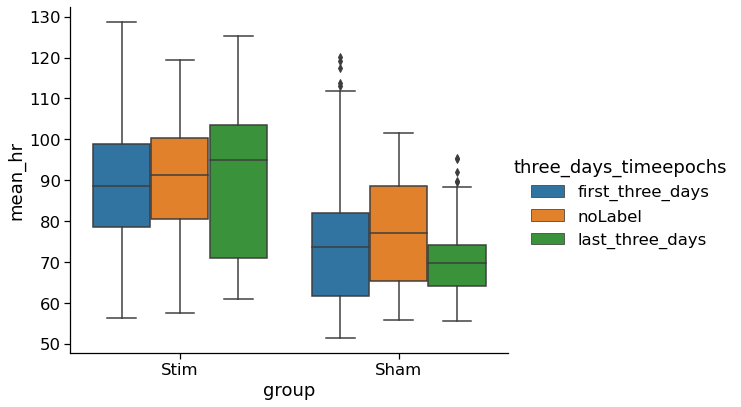

In [349]:
sns.set_context("notebook", font_scale=1.5)
plt.figure(figsize=(10,8))
sns.catplot(x='group', 
            y=dependent_var,
            hue="three_days_timeepochs",
            kind="box",
            data=df_hrv, 
            height=6, 
            aspect=1.3);

## Section 2: HRV of 1 hour

In [352]:
# extraction
df_nn_1hour = pd.read_csv(features_nn_1hour_fName, index_col=0)
df_nn_1hour = df_nn_1hour.dropna()
noon = 12 * 60 * 60
data2df_hrv_1hour = []
for subj in pd.unique(df_nn_1hour['subject']):
    df_temp = df_nn_1hour[df_nn_1hour['subject']==subj]  # temporary df to retrieve stim dates for a subject  
    for date in pd.unique(df_temp['date']):
        data2calculate_hrv = df_nn_1hour[(df_nn_1hour['subject']==subj) & (df_nn_1hour['date']==date)]        
        time_domain_features = get_time_domain_features(data2calculate_hrv['nn_interval'].astype(float))
        frequency_domain_features = get_frequency_domain_features(data2calculate_hrv['nn_interval'].astype(float))
        data2df_hrv_1hour.append([subj, date, data2calculate_hrv['group'].values[0]] +
                                   list(time_domain_features.values()) +\
                                   list(frequency_domain_features.values()))

df_hrv_1hour = pd.DataFrame(data2df_hrv_1hour, columns=['subject', 'date', 'group'] + list(time_domain_features.keys()) +
                      list(frequency_domain_features.keys()))
features_hrv_1hour_fName = os.path.join('/Users/ganshengt/Box/taVNS_clinical/features', 'features_hrv_1hour.csv')
df_hrv_1hour.to_csv(features_hrv_1hour_fName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


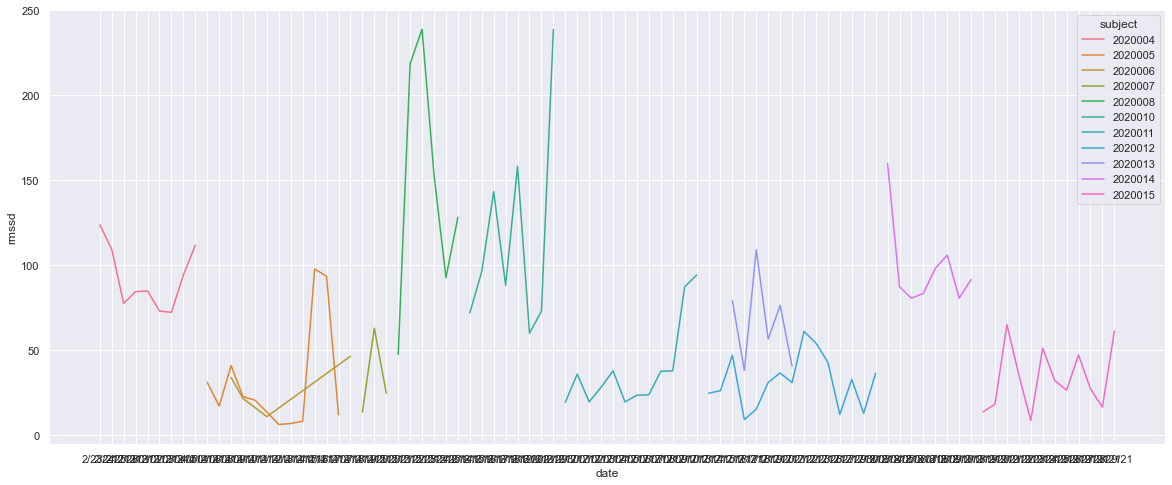

In [361]:
sns.set(rc={'figure.figsize':(20,8)})
df_hrv_1hour['subject'] = df_hrv_1hour['subject'].astype('str')
sns.lineplot(data=df_hrv_1hour, x="date", y="rmssd", hue="subject")
plt.savefig(os.path.join('/Users/ganshengt/Box/taVNS_clinical/features', 'features_hrv_1hour.eps'))